In [5]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model

def CNN_ECG_model(input_shape):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional block
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third convolutional block
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth convolutional block
    x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the feature maps into a 1D feature vector
    x = Flatten()(x)

    # Fully connected layer with dropout
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [18]:
CNN_ECG = CNN_ECG_model((224,224,3))
CNN_ECG.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256  

In [19]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
CNN_ECG.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy',precision,recall,f1_score])


In [20]:
import os
import numpy as np
from keras.preprocessing import image

def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    label_map = {'normal': 0, 'abnormal': 1}
    
    for label in label_map.keys():
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array *= (1.0/255)  # Apply rescaling
            images.append(img_array)
            labels.append(label_map[label])
            
    return np.array(images), np.array(labels)

In [21]:
# Define path to main directory containing normal and abnormal subdirectories
ECG_path = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided"


In [22]:
# Load actual data arrays for ECG and PCG

X_train_ecg, y_train_ecg = load_images_from_directory(ECG_path, target_size=(224, 224))

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_ecg, X_val_ecg, y_train, y_val_ecg = train_test_split(X_train_ecg, y_train_ecg, test_size=0.2, random_state=41)

In [25]:
print(y_val_ecg)

[1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 

In [26]:
from keras.callbacks import EarlyStopping

# Assuming X_train_ecg, X_val_ecg, and y_train_ecg are defined elsewhere
# Define and configure early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Train the model and store the training history
history = CNN_ECG.fit(
    [X_train_ecg],  # Input data: PCG and ECG images
    y_train,                  # Target labels
    batch_size=64,                # Batch size
    epochs=100,                   # Number of epochs
    validation_data=([X_val_ecg], y_val_ecg),  # Fraction of training data used for validation
    callbacks=[early_stopping_callback]  # Callbacks for early stopping and model checkpoint
)

Epoch 1/100


44/44 [==============================] - 99s 2s/step - loss: 7.2723 - accuracy: 0.7177 - precision: 0.7963 - recall: 0.8021 - f1_score: 0.7825 - val_loss: 0.5759 - val_accuracy: 0.7356 - val_precision: 0.7408 - val_recall: 0.9727 - val_f1_score: 0.8395
Epoch 2/100
44/44 [==============================] - 87s 2s/step - loss: 0.4500 - accuracy: 0.8191 - precision: 0.8575 - recall: 0.8978 - f1_score: 0.8744 - val_loss: 0.5908 - val_accuracy: 0.7069 - val_precision: 0.7228 - val_recall: 0.9605 - val_f1_score: 0.8231
Epoch 3/100
44/44 [==============================] - 86s 2s/step - loss: 0.3067 - accuracy: 0.8695 - precision: 0.8925 - recall: 0.9301 - f1_score: 0.9096 - val_loss: 0.6062 - val_accuracy: 0.7141 - val_precision: 0.7235 - val_recall: 0.9716 - val_f1_score: 0.8280
Epoch 4/100
44/44 [==============================] - 86s 2s/step - loss: 0.2706 - accuracy: 0.8903 - precision: 0.9053 - recall: 0.9483 - f1_score: 0.9247 - val_loss: 0.6461 - val_accuracy: 0.7055 - val_

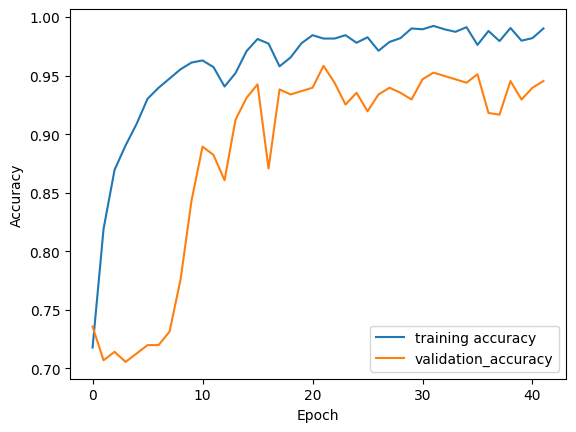

In [27]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

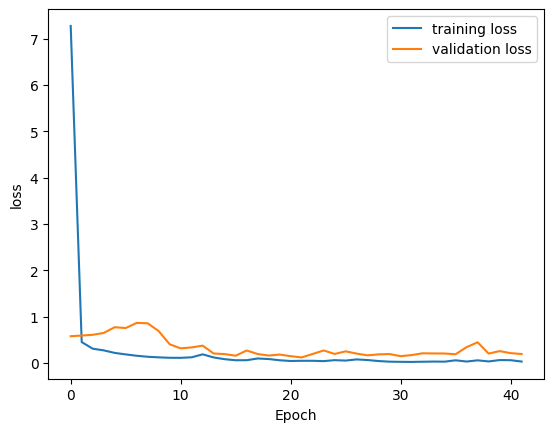

In [28]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [29]:
CNN_ECG.save(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\CNN_syamese\CNN_ECG_syamese\CNN_ECG_syamese_epoch_22.keras")

In [30]:
from tensorflow.keras.models import load_model
CNN_ECG = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\CNN_syamese\CNN_ECG_syamese\CNN_ECG_syamese_epoch_22.keras",custom_objects={'precision': precision, 'recall': recall, 'f1_score': f1_score})

In [31]:
y_pred_prob_train = CNN_ECG.predict([X_train_ecg])

87/87 [==============================] - 20s 230ms/step


In [32]:
y_pred_train = np.round(y_pred_prob_train)

In [33]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_train = confusion_matrix(y_train, y_pred_train)

print("cm ecg train:",cm_fused_train)

cm ecg train: [[ 790   15]
 [   7 1969]]


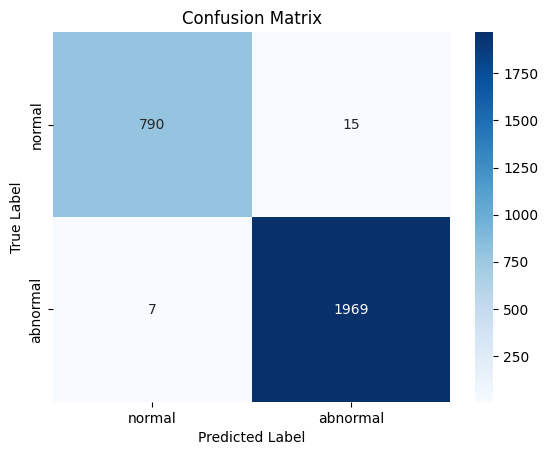

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       805
           1       0.99      1.00      0.99      1976

    accuracy                           0.99      2781
   macro avg       0.99      0.99      0.99      2781
weighted avg       0.99      0.99      0.99      2781



In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_train, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

In [35]:
y_pred_prob_val = CNN_ECG.predict([X_val_ecg])

22/22 [==============================] - 5s 224ms/step


In [36]:
y_pred_val = np.round(y_pred_prob_val)

In [37]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_val = confusion_matrix(y_val_ecg, y_pred_val)

print("cm fused val:",cm_fused_val)

cm fused val: [[179  21]
 [  8 488]]


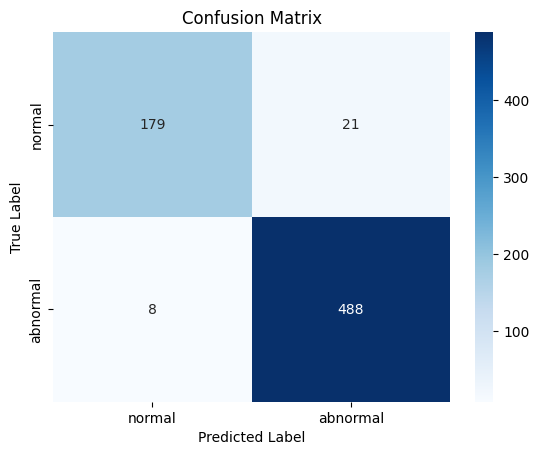

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       200
           1       0.96      0.98      0.97       496

    accuracy                           0.96       696
   macro avg       0.96      0.94      0.95       696
weighted avg       0.96      0.96      0.96       696



In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_val, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_val_ecg, y_pred_val))

In [39]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[0][0]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [40]:
cm_fused_val=[[179,  21],[  8, 488]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.9587426326129665
Recall (Sensitivity): 0.9838709677419355
F1 Score: 0.9711442786069652
Accuracy: 0.9583333333333334
specificity: 0.895


In [41]:
cm_fused_train=[[ 790  , 15], [   7, 1969]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_fused_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 0.9924395161290323
Recall (Sensitivity): 0.9964574898785425
F1 Score: 0.9944444444444445
Accuracy: 0.992089176555196
specificity: 0.9813664596273292


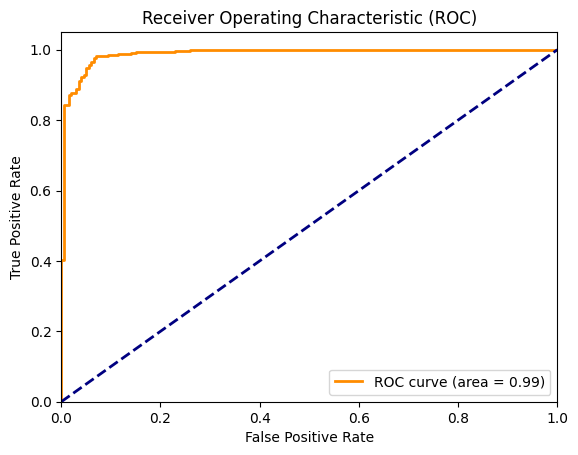

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val_ecg, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

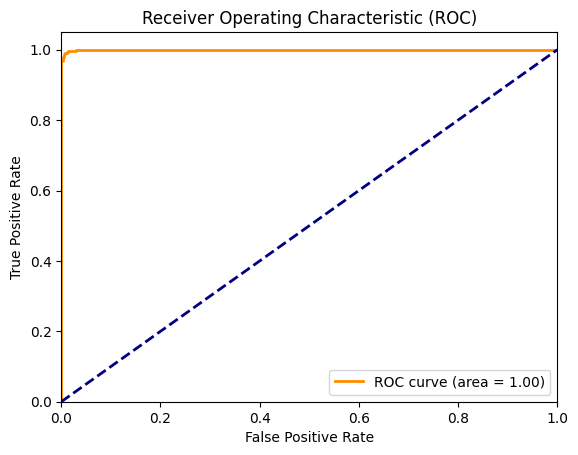

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

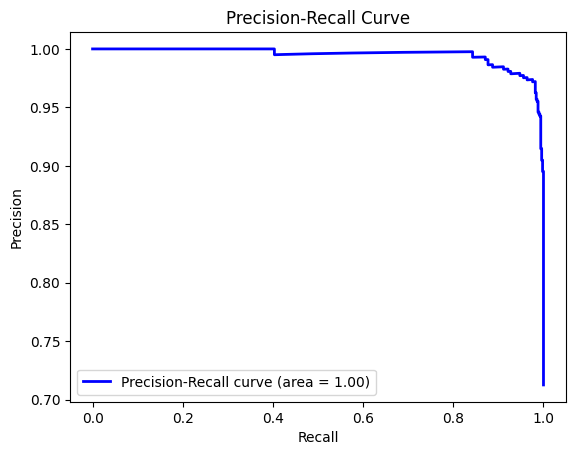

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val_ecg, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

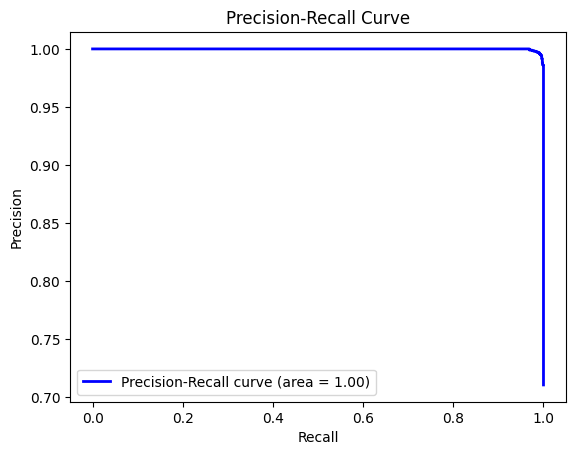

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()